### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [54]:
from os.path import isdir
from os import mkdir

env = 'pc'  # 'pc', 'colab'
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/full_testing/'
experiment = 'Exp4/'

save_dir = ''
if env == 'pc':
    save_dir = f'C:/Users/79137/Pasha/2. UNIPD/Semester 2/Optimization for Data Science/Homeworks/HW 1/Semi-Supervised-Labelling/'
elif env == 'colab':
    save_dir = f'/content/drive/MyDrive/UNIPD/ODS/HW1/'

In [55]:
%%capture

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

# Saving directory

In [56]:
full_dir = f'{save_dir}{experiment}'
assert(isdir(save_dir))

if not isdir(full_dir):
    mkdir(full_dir)

assert(isdir(full_dir))

In [57]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt

In [58]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [59]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

In [60]:
# %%timeit
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)


def euclidian_similarity(Xi, Xj):
    return 1 / (norm(Xi - Xj) + 0.001)

In [61]:
# %%timeit

# Old inefficient weights calculation
# weights = calc_weight_matrix(X, weight_func = None)

from sklearn.metrics import pairwise_distances

weights = pairwise_distances(X, metric = 'euclidean')
weights = 1 / (weights + 0.001)
assert(weights.shape == (DataProperties.n_samples, DataProperties.n_samples))

Data shape: X: (1000, 2), Y: (1000,)


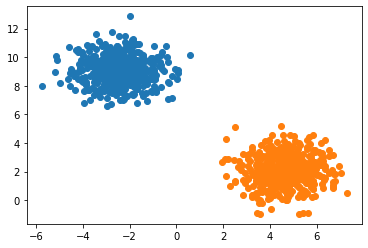

In [62]:
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 500 instances of object 0.0
We have to delabel 475 instances
Found 500 instances of object 1.0
We have to delabel 475 instances

    We have 950 unlabeled data
    Out of 1000
    


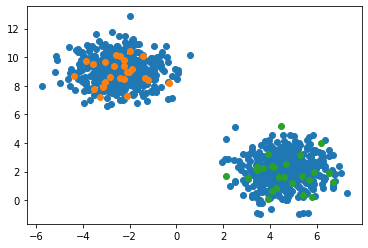

In [63]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [64]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled
print(class_stats)

Counter({-1000000.0: 950, 1.0: 25, 0.0: 25})


# Gradient descent

In [65]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.00001
)

In [66]:
Y_preds_GD = solver.solve(
    X, 
    Y_delabeled,
    Y_true = Y,
    iter_limit = 6,
    delta_loss_limit = 0.008, 
    stop_loss = 150,
    weight_matrix = weights
)

Iteration: 0, Loss: 5852.532638241639, delta loss: 5852.532638241639
Iteration: 1, Loss: 5847.8895334308245, delta loss: 4.643104810814293
Iteration: 2, Loss: 5843.285504518953, delta loss: 4.604028911871865
Iteration: 3, Loss: 5838.719969309425, delta loss: 4.565535209527297
Iteration: 4, Loss: 5834.192358199942, delta loss: 4.527611109483587
Iteration: 5, Loss: 5829.702113869112, delta loss: 4.490244330830137




Accuracy: 1.0


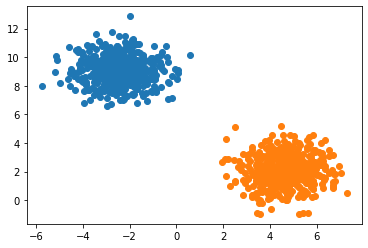

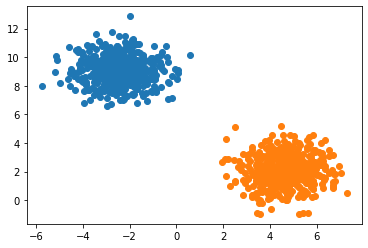

In [67]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

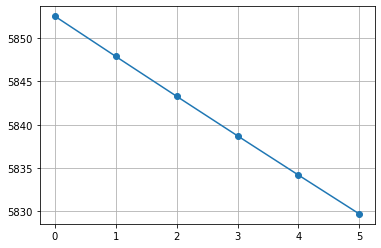

In [68]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

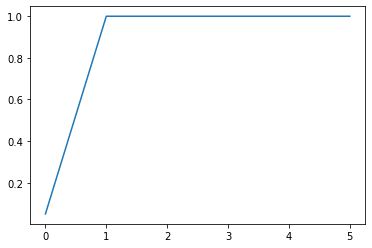

In [69]:
plt.plot(solver.accuracies)

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [70]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [72]:
Y_preds_BCGD_permutation = random_solver.solve(
    X, 
    Y_delabeled, 
    Y_true = Y,
    iter_limit = 6,
    delta_loss_limit = 0.008,
    stop_loss= 2174,
    weight_matrix = weights
)

Iteration: 0, Loss: 5852.532638241639, Delta: 5852.532638241639
Iteration: 1, Loss: 5375.26374520883, Delta: 477.2688930328086
Iteration: 2, Loss: 5178.988732639806, Delta: 196.2750125690245
Iteration: 3, Loss: 5100.1959194973815, Delta: 78.79281314242417
Iteration: 4, Loss: 5066.933428638143, Delta: 33.262490859238824
Iteration: 5, Loss: 5051.893944262718, Delta: 15.039484375424763


Accuracy: 1.0


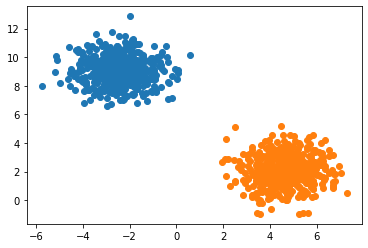

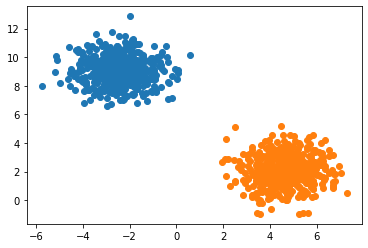

In [73]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

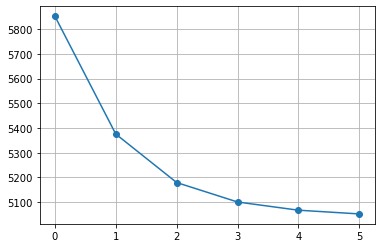

In [74]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

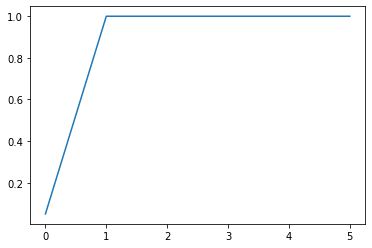

In [75]:
plt.plot(random_solver.accuracies)

## BCGD random sampling

In [76]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'random sampling'
)

In [2]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled,
    Y_true = Y,
    iter_limit = 10, #  * len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]),
    delta_loss_limit = 0.0,
    stop_loss= 210,
    weight_matrix = weights
)

NameError: name 'BCGD_RS_solver' is not defined

Accuracy: 0.5455


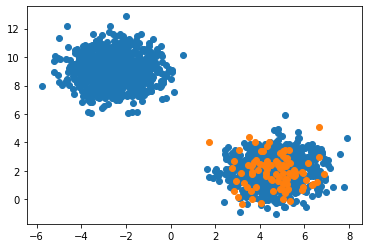

In [ ]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

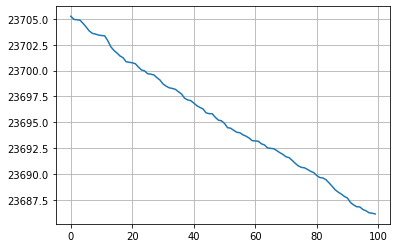

In [ ]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

## BCGD cyclic

In [45]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.00001,
    similarity_func = None,

    bcgd_strategy = 'cyclic'
)

In [46]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    Y_true = Y,
    iter_limit = 10, 
    delta_loss_limit = 0.0001,
    stop_loss = 2300,
    weight_matrix = weights
)

Iteration: 0, Loss: 1761360.4200700333, Delta: 1761360.4200700333
Iteration: 1, Loss: 1736108.4474343853, Delta: 25251.97263564798
Iteration: 2, Loss: 1735116.3222185893, Delta: 992.1252157960553
Iteration: 3, Loss: 1735031.0852387375, Delta: 85.23697985173203


KeyboardInterrupt: ignored

Accuracy: 1.0


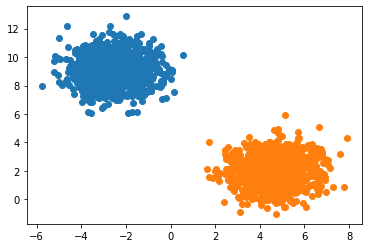

In [ ]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

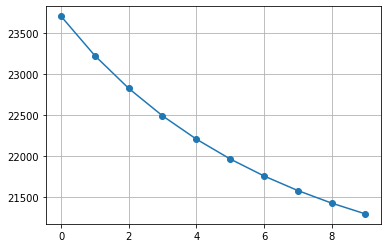

In [ ]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [53]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.00001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    # 'BCGD sampling': bcgd_sampling_solver,
}

In [54]:
def compare_models(solvers_dict, X, Y_delabeled, iters_limit, delta_loss_limit, stop_loss, weights_matrix):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times_total = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        print(f'Fitting {model_name}')
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss,
            weight_matrix = weights_matrix
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times_total[model_name] = end - start
    

    return predictions, losses, n_iterations, cpu_times_total

In [55]:
iters_limit = 15
delta_loss_limit = 0.0001
stop_loss= 1735000  # 4000


preds, losses, n_iters, cpu_times_total = compare_models(
        solvers,
        X,
        Y_delabeled,
        iters_limit = iters_limit,
        delta_loss_limit = delta_loss_limit,
        stop_loss = stop_loss,
        weights_matrix =  weights
    )

accuracies = {name: accuracy_score(preds[name], Y) for name in solvers.keys()}
cpu_times = {name: solver.cpu_times for name, solver in solvers.items()}

Fitting GD
Iteration: 0, Loss: 1761360.4200700333, delta loss: 1761360.4200700333
Iteration: 1, Loss: 1735154.3172182278, delta loss: 26206.10285180551
Iteration: 2, Loss: 1735037.9463347571, delta loss: 116.370883470634
Iteration: 3, Loss: 1735021.4502049692, delta loss: 16.496129787992686
Iteration: 4, Loss: 1735016.980884067, delta loss: 4.469320902135223
Iteration: 5, Loss: 1735014.331794235, delta loss: 2.649089832091704
Iteration: 6, Loss: 1735012.0791837336, delta loss: 2.2526105013675988
Iteration: 7, Loss: 1735009.9982284906, delta loss: 2.0809552429709584
Iteration: 8, Loss: 1735008.0458236139, delta loss: 1.952404876705259
Iteration: 9, Loss: 1735006.2087508799, delta loss: 1.837072734022513
Iteration: 10, Loss: 1735004.4792479188, delta loss: 1.7295029610395432
Iteration: 11, Loss: 1735002.850840333, delta loss: 1.628407585900277
Iteration: 12, Loss: 1735001.3175854515, delta loss: 1.533254881389439
Iteration: 13, Loss: 1734999.87391678, delta loss: 1.4436686714179814


Fit

## Saving data

In [56]:
# iters_limit = 17
# delta_loss_limit = 0.0001
# stop_loss= 21000  # 4000

experiment_params = pd.DataFrame(
    {
        'iters_limit': [iters_limit],
        'd_loss_limit': [delta_loss_limit],
        'stop_loss': [stop_loss],
        'learning_rate': [lr],
        'n points': [DataProperties.n_samples]
    },
    # index = False
)

experiment_params.head()
experiment_params.to_csv(full_dir + 'experiment_params.csv')

In [57]:
results = pd.DataFrame()

# fill losses
for model_name, loss in losses.items():
    new = pd.DataFrame({model_name: loss})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} loss'] = loss

for model_name, cpu_time in cpu_times.items():
    new = pd.DataFrame({model_name: cpu_time})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} cpu'] = cpu_time


results.to_csv(full_dir + 'res.csv')
results.head()

,GD,BCGD permutation,BCGD cyclic,GD,BCGD permutation,BCGD cyclic
0,1.761360e+06,1.761360e+06,1.761360e+06,31.623768,31.816271,31.420655
1,1.735154e+06,1.736112e+06,1.736108e+06,90.932542,91.634096,91.074962
2,1.735038e+06,1.735107e+06,1.735116e+06,150.570396,152.074074,150.922679
3,1.735021e+06,1.735029e+06,1.735031e+06,209.978475,212.575217,210.639681
4,1.735017e+06,1.735017e+06,1.735015e+06,269.382976,273.232659,270.993339


,CPU total time,N iterations,Accuracies,CPU total time_norm,N iterations_norm,Accuracies_norm
GD,807.288768,13,0.05,1.000000,1.000000,1.0
BCGD permutation,693.521045,11,0.05,0.859074,0.846154,1.0
BCGD cyclic,631.782088,10,0.05,0.782597,0.769231,1.0


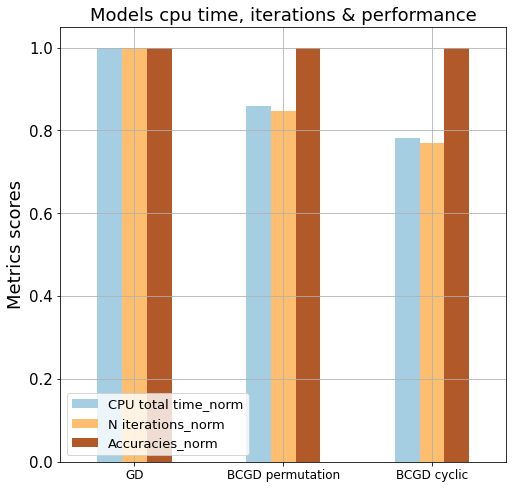

In [59]:
bar_metrics = pd.DataFrame.from_dict(cpu_times_total, orient='index', columns = ['CPU total time'])
bar_metrics['N iterations'] = n_iters.values()
bar_metrics['Accuracies'] = accuracies.values()



normalize_cols(bar_metrics)
cols_to_plot = [c for c in bar_metrics.columns if 'norm' in c]

plot_bar_metrics(bar_metrics.loc[:, cols_to_plot])
bar_metrics.to_csv(full_dir + 'metrics res.csv')

bar_metrics.head()

## Graphics

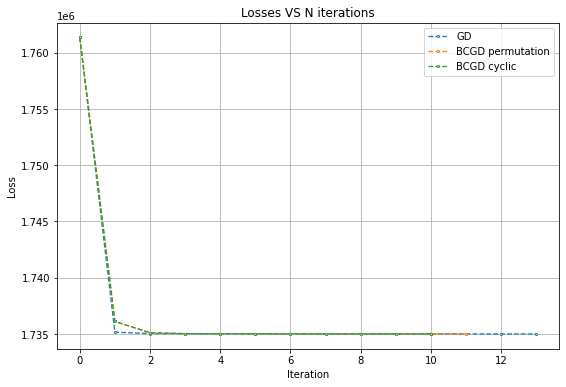

In [60]:
def plot_curves(curves_dict, title, y_label, figsize):
    _, ax = plt.subplots(figsize = figsize)

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


# plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
# plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(
    losses,
    'Losses VS N iterations', 
    y_label = 'Loss',
    figsize = (9, 6)
)

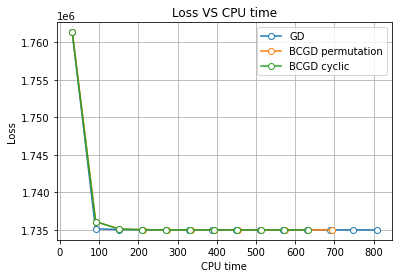

In [70]:
def plot_losses_vs_cpu(losses_, cpu_times_):
    assert(list(losses_.keys()) == list(cpu_times_.keys()))

    _, ax = plt.subplots()

    for model_name, loss in losses_.items():
        cpu_time = cpu_times_[model_name]

        ax.plot(
            cpu_time,
            loss,
            marker = 'o',
            markerfacecolor = 'white'
        )
    plt.xlabel('CPU time')
    plt.ylabel('Loss')
    plt.title('Loss VS CPU time')
    plt.legend(list(losses_.keys()))
    plt.grid()


plot_losses_vs_cpu(losses, cpu_times)

# Real dataset

In [ ]:
# df = pd.read_csv('Pokemon.csv')

In [ ]:
# df.head()

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [ ]:
# df.head()
# X_real = df.loc[:, ['total', 'sp_attack']].values
# Y_real = df['legendary'].astype('int').values


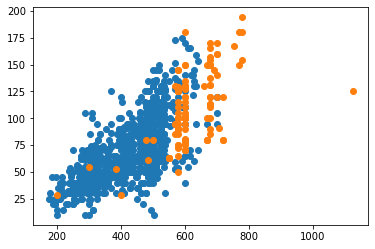

In [ ]:
# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# Y_real_delabeled = delabel_data(
#     Y_real,
#     labeled_percent = 0.16, # DataProperties.labeled_percentage,
#     delabel_value = DataProperties.unlabeled
# )

Found 954 instances of object 0
We have to delabel 801 instances
Found 118 instances of object 1
We have to delabel 99 instances


In [ ]:
# wine=datasets.load_wine()

# #Conver to pandas dataframe
# data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

# data = data.loc[
#     (data['target'] == 1) | (data['target'] == 0),
#     ['od280/od315_of_diluted_wines', 'alcohol', 'target']
# ]

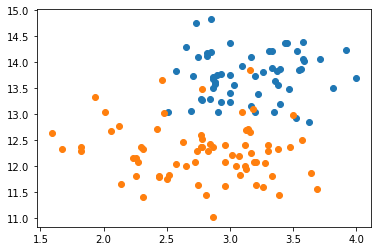

In [ ]:
# X_real = data.loc[
#     :,
#     ['od280/od315_of_diluted_wines', 'alcohol']
# ].values
# Y_real = data['target'].values

# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# solver = GradientDescentSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.0001,
#     similarity_func = None
# )

# Y_real_preds = solver.solve(
#     X_real,
#     Y_real_delabeled,
#     iter_limit=5,
#     delta_loss_limit = 0.003,
#     stop_loss = 20
# )

Iteration: 0, Loss: 24173.807351957803, delta loss: 24173.807351957803
Iteration: 1, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 2, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 3, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 4, Loss: 24173.807351957803, delta loss: 0.0


